<a href="https://colab.research.google.com/github/adarsh0raj/SoC-CNN/blob/master/multiclass_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database 
!unzip /content/*.zip

In [ ]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical

path = '/content/'

In [ ]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


In [ ]:
#3616 COVID-19 positive, 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images
#Datasets split as: 875 COVID-19 positive, 2125 Normal, 336 Viral Pneumonia (total 3336) per set
#4 sets in total

In [ ]:
#@title Functions

def create_dataset_multi(n):
    arraycov = np.array([cv.imread(file, 0) for file in glob.glob('/content/COVID-19_Radiography_Dataset/COVID/*.png')])[875*(n-1):875*n]/255.0
    arraynorm = np.array([cv.imread(file, 0) for file in glob.glob('/content/COVID-19_Radiography_Dataset/Normal/*.png')])[2125*(n-1):2125*n]/255.0
    arraypneu = np.array([cv.imread(file, 0) for file in glob.glob('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/*.png')])[336*(n-1):336*n]/225.0
    print("Step 1: Completed")

    ncov = len(arraycov)
    nnorm = len(arraynorm)
    npneu = len(arraypneu)

    data_x = np.vstack((arraycov, arraynorm, arraypneu))
    data_y = np.zeros((ncov+nnorm+npneu,1))

    for i in range(ncov):
        data_y[i] = 1       
    for i in range(ncov+nnorm,ncov+nnorm+npneu):
        data_y[i] = 2    
    print("Step 2: Completed")

    np.save(path + 'Datasets/data_set_multi' + str(n), data_x)
    np.save(path + 'Datasets/feature_set_multi' + str(n), data_y)

    print("Process Complete")

def train_test_data_multi(dataset_num, blur_index):
    data_x = np.load(path + 'Datasets/data_set_multi' + str(dataset_num) + '.npy')
    data_y = np.load(path + 'Datasets/feature_set_multi' + str(dataset_num) + '.npy')

    data_x = cv.GaussianBlur(data_x, (3, 3), blur_index)

    sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 69)
    for train_index, test_index in sss.split(data_x, data_y):
        train_x, train_y = data_x[train_index], data_y[train_index]
        test_x, test_y = data_x[test_index], data_y[test_index]
    
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    m_train = len(train_x)
    m_test = len(test_x)
    
    train_x, test_x = train_x.reshape(m_train,299,299,1), test_x.reshape(m_test,299,299,1)

    print("X data (Training set): ", train_x.shape)
    print("Y data (Training set): ", train_y.shape)
    print("X data (Test set): ", test_x.shape)
    print("Y data (Test set): ", test_y.shape)

    return train_x, train_y, test_x, test_y, m_train, m_test   

##Importing Datasets

In [ ]:
train_x, train_y, test_x, test_y, m_train, m_test = train_test_data_multi(2, 3)

X data (Training set):  (2335, 299, 299, 1)
Y data (Training set):  (2335, 3)
X data (Test set):  (1001, 299, 299, 1)
Y data (Test set):  (1001, 3)


In [ ]:
train_x2, train_y2, test_x22, test_y2, m_train2, m_test2 = train_test_data_multi(3, 3)

X data (Training set):  (2335, 299, 299, 1)
Y data (Training set):  (2335, 3)
X data (Test set):  (1001, 299, 299, 1)
Y data (Test set):  (1001, 3)


##Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.losses import CategoricalCrossentropy
from keras.optimizers import SGD
from keras import backend as k
from tqdm.keras import TqdmCallback

In [ ]:
def append_history(m1, m2):
    m1.history['accuracy'] = np.append(m1.history['accuracy'], m2.history['accuracy'])
    m1.history['val_accuracy'] = np.append(m1.history['val_accuracy'], m2.history['val_accuracy'])
    m1.history['loss'] = np.append(m1.history['loss'], m2.history['loss'])
    m1.history['val_loss'] = np.append(m1.history['val_loss'], m2.history['val_loss'])

    return m1    

In [ ]:
model = Sequential([
                    Conv2D(96, (11,11), strides = (4,4), activation = 'relu', input_shape = (299,299,1)),
                    MaxPool2D((3,3), strides = (2,2)),
                    Conv2D(128, (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
                    BatchNormalization(),
                    Conv2D(128, (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
                    MaxPool2D((3,3), strides = (2,2)),
                    Dropout(0.5),
                    Conv2D(128, (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
                    BatchNormalization(),
                    Conv2D(128, (5,5), strides = (1,1), activation = 'relu', padding = 'same'),
                    MaxPool2D((3,3), strides = (2,2)),
                    Dropout(0.2),
                    Conv2D(128, (5,5), strides = (1,1), groups = 2, activation = 'relu', padding = 'same'),
                    MaxPool2D((3,3), strides = (2,2)),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(3, activation = 'softmax')
  ])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 73, 73, 96)        11712     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 128)       307328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 36, 128)       512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 128)       409728    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)      

In [ ]:
optimizer = SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(optimizer = optimizer, loss = CategoricalCrossentropy(), metrics = ['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, batch_size = 64, 
                    validation_data = (test_x,test_y), validation_batch_size = 64, 
                    epochs = 100, verbose = 0, callbacks = [TqdmCallback(verbose=0)])

k.set_value(model.optimizer.learning_rate, 0.0001)

history1 = model.fit(train_x2, train_y2, batch_size = 64, 
                     validation_data = (test_x,test_y), validation_batch_size = 64, 
                     epochs = 400, verbose = 0, callbacks = [TqdmCallback(verbose=0)])

In [ ]:
model.evaluate(test_x, test_y)

32/32 [==============================] - 1s 20ms/step - loss: 0.1399 - accuracy: 0.9600


[0.13994142413139343, 0.9600399732589722]

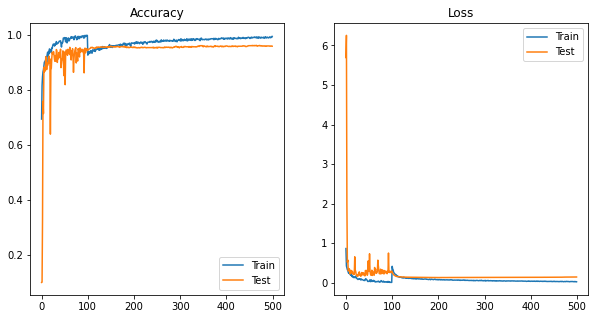

In [ ]:
history = append_history(history, history1)

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title("Loss")
plt.legend()

plt.show()

In [ ]:
model.save(path + 'Models/set2_multi_v2.h5')

In [ ]:
from keras.models import load_model
model2 = load_model(path + 'Models/set2_multi_v2.h5')

In [ ]:
results = np.array((model2.evaluate(test_x, test_y),
                   model2.evaluate(test_x22, test_y2)))
np.average(results, axis = 0)

32/32 [==============================] - 1s 18ms/step - loss: 0.1411 - accuracy: 0.9620


array([0.14050549, 0.96103898])

In [ ]:
#@title
#EPOCHS = 12

#start_lr = 0.00001
#min_lr = 0.00001
#max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
#rampup_epochs = 5
#sustain_epochs = 0
#exp_decay = .8

#def lrfn(epoch):
#  if epoch < rampup_epochs:
#    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
#  elif epoch < rampup_epochs + sustain_epochs:
#    return max_lr
#  else:
#    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

#rang = np.arange(EPOCHS)
#y = [lrfn(x) for x in rang]
#plt.plot(rang, y)
#print('Learning rate per epoch:')

In [ ]:
#@title
#history = model.fit(train_x, train_y, validation_data=(test_x, test_y),
#                    steps_per_epoch = train_steps, epochs=EPOCHS, callbacks=[lr_callback])

#final_accuracy = history.history["val_accuracy"][-5:]
#print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))